<a href="https://colab.research.google.com/github/Aduomas/PP7/blob/main/Practical_Project_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

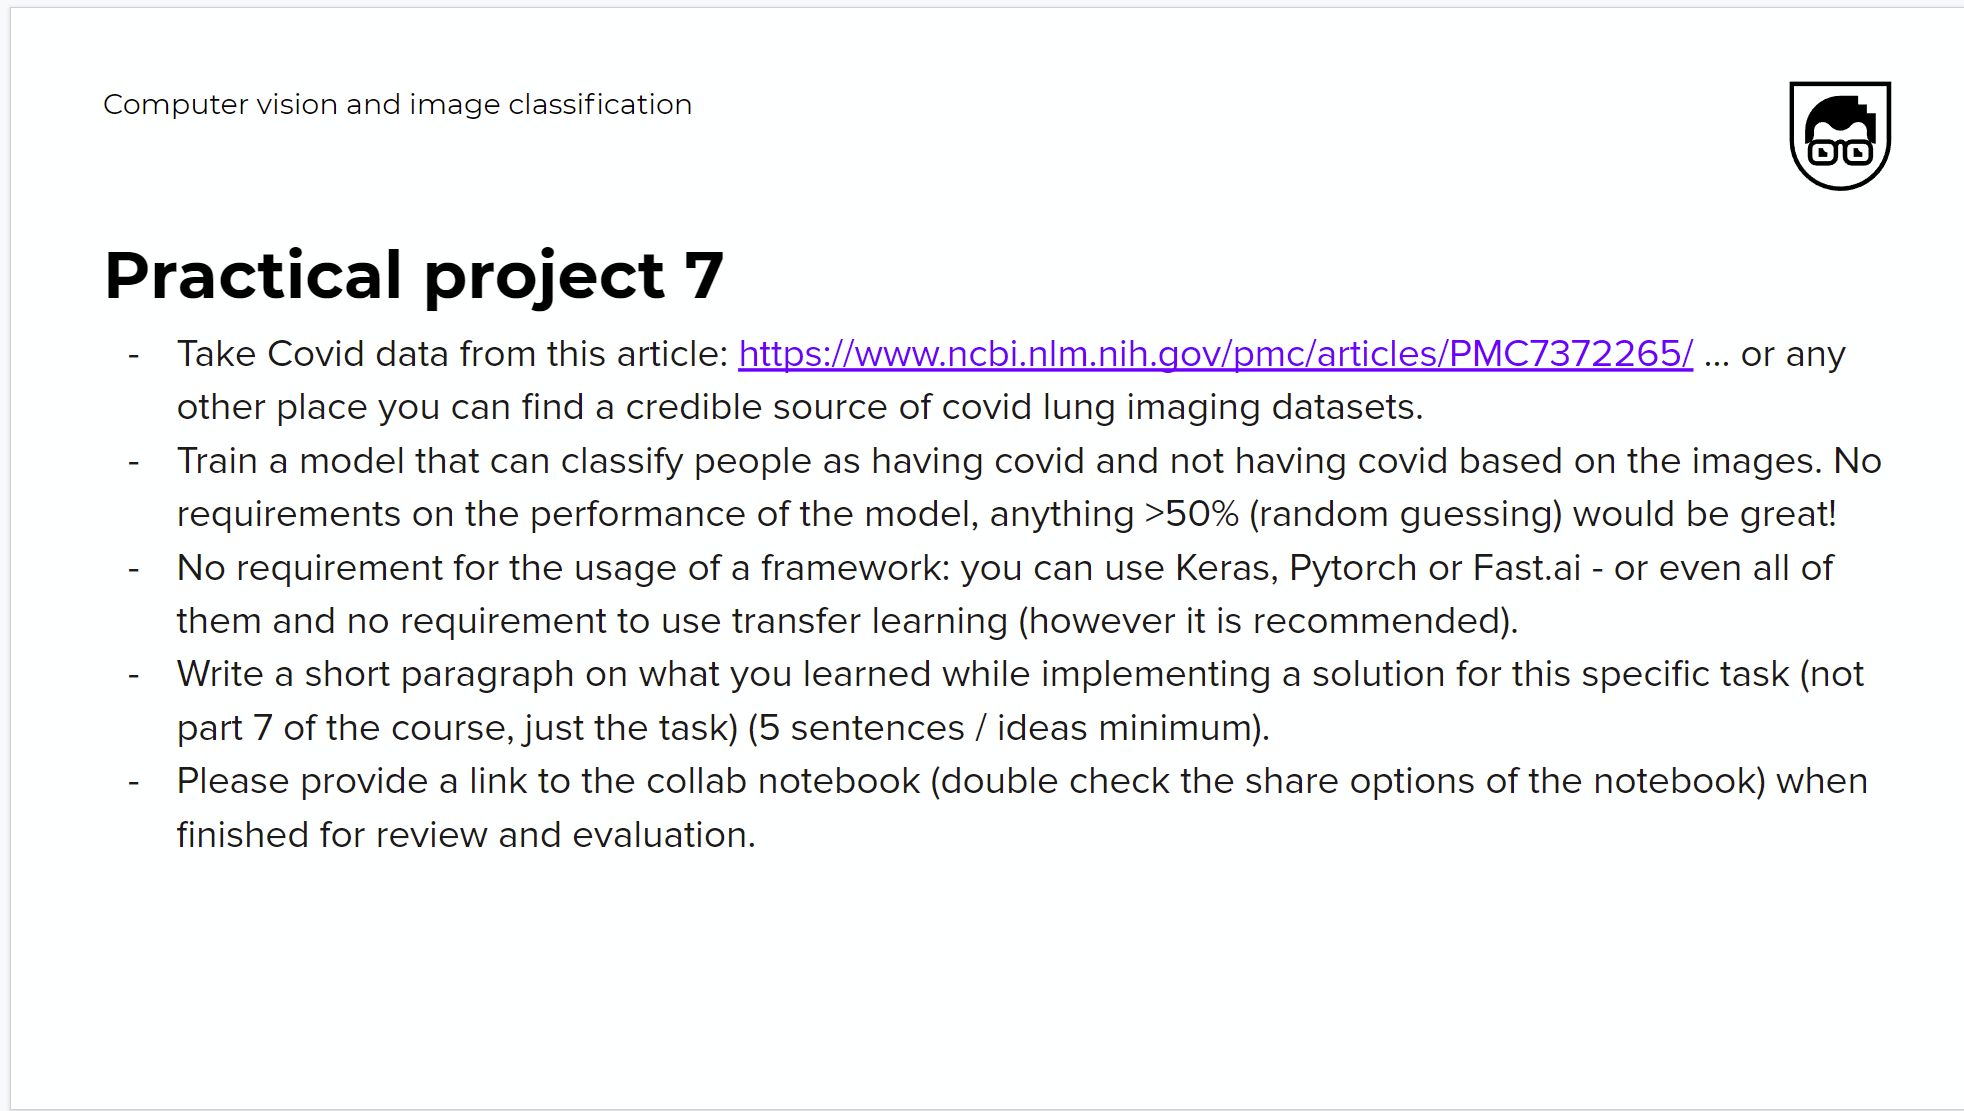

### Dataset
https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json (api key)
# output cleared

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download 'tawsifurrahman/covid19-radiography-database'

100% 744M/745M [00:21<00:00, 51.5MB/s]
100% 745M/745M [00:21<00:00, 36.3MB/s]


In [ ]:
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

### Import Libraries

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os 

### Path

In [ ]:
os.makedirs('./COVID19-DATASET/train/covid19')
os.makedirs('./COVID19-DATASET/train/normal')

In [ ]:
os.makedirs('./COVID19-DATASET/test/covid19')
os.makedirs('./COVID19-DATASET/test/normal')

In [ ]:
COVID_PATH = './COVID-19_Radiography_Dataset/COVID'
NORMAL_PATH = './COVID-19_Radiography_Dataset/Normal'

### Define Params

In [ ]:
IMAGE_SIZE = [224, 224]

# Set the batch size
BATCH_SIZE = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
NUM_CLASSES = 2 # We are aware of it.

### Test/Train split

In [ ]:
from os import walk
_, _, filenames_covid = next(walk(COVID_PATH), (None, None, []))
_, _, filenames_normal = next(walk(NORMAL_PATH), (None, None, []))

In [ ]:
len(filenames_covid)

3616

In [ ]:
import shutil, os, random
fromDirectory= './COVID-19_Radiography_Dataset/COVID/'
toDirectory='./COVID19-DATASET/test/covid19/'
random.shuffle(filenames_covid)
for f in filenames_covid[:700]:
   shutil.copy(fromDirectory + f, toDirectory)
toDirectory='./COVID19-DATASET/train/covid19/'
for f in filenames_covid[700:]:
   shutil.copy(fromDirectory + f, toDirectory)

In [ ]:
len(filenames_normal)

10192

In [ ]:
import shutil, os, random
fromDirectory= './COVID-19_Radiography_Dataset/Normal/'
toDirectory='./COVID19-DATASET/test/normal'
random.shuffle(filenames_normal)
for f in filenames_normal[:2000]:
   shutil.copy(fromDirectory + f, toDirectory)
toDirectory='./COVID19-DATASET/train/normal/'
for f in filenames_normal[2000:]:
   shutil.copy(fromDirectory + f, toDirectory)

In [ ]:
train_path = './COVID19-DATASET/train'
test_path = './COVID19-DATASET/test'

In [ ]:
import os
CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)

### Load Images

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [ ]:
training_set = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 11108 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
test_set = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 2700 images belonging to 2 classes.


### Model (MobileNetV2) - Keras

In [ ]:
mobnet = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in mobnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(mobnet.output)

prediction = Dense(NUM_CLASSES, activation='softmax')(x)

In [ ]:
model = Model(inputs=mobnet.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
432/432 [==============================] - 637s 1s/step - loss: 1.1110 - accuracy: 0.8890 - val_loss: 0.2953 - val_accuracy: 0.9635
Epoch 2/5
432/432 [==============================] - 636s 1s/step - loss: 0.8446 - accuracy: 0.9212 - val_loss: 0.7629 - val_accuracy: 0.9168
Epoch 3/5
432/432 [==============================] - 658s 2s/step - loss: 0.9072 - accuracy: 0.9300 - val_loss: 2.9941 - val_accuracy: 0.8211
Epoch 4/5
432/432 [==============================] - 674s 2s/step - loss: 0.8600 - accuracy: 0.9371 - val_loss: 0.7789 - val_accuracy: 0.9367
Epoch 5/5
432/432 [==============================] - 677s 2s/step - loss: 0.8046 - accuracy: 0.9455 - val_loss: 0.3001 - val_accuracy: 0.9754


### Save Model - 95% acc

In [ ]:
model.save('mobile_net_v2_covid.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Loss vs Epoch

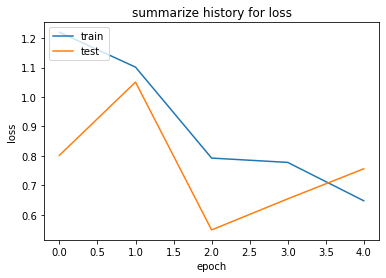

In [ ]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation (Test) loss')
plt.title('summarize history for loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Accuracy vs Epoch

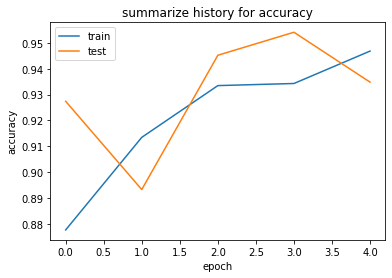

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('summarize history for accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predict

In [ ]:
!wget http://www.itnonline.com/sites/default/files/Chest.jpeg

--2021-12-29 22:29:07--  http://www.itnonline.com/sites/default/files/Chest.jpeg
Resolving www.itnonline.com (www.itnonline.com)... 104.18.13.65, 104.18.12.65, 2606:4700::6812:d41, ...
Connecting to www.itnonline.com (www.itnonline.com)|104.18.13.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.itnonline.com/sites/default/files/Chest.jpeg [following]
--2021-12-29 22:29:07--  https://www.itnonline.com/sites/default/files/Chest.jpeg
Connecting to www.itnonline.com (www.itnonline.com)|104.18.13.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1537670 (1.5M) [image/jpeg]
Saving to: ‘Chest.jpeg’

Chest.jpeg          100%[===================>]   1.47M  --.-KB/s    in 0.02s   

2021-12-29 22:29:07 (62.6 MB/s) - ‘Chest.jpeg’ saved [1537670/1537670]



In [ ]:
img_covid = image.load_img('Chest.jpeg', target_size=(224, 224))

In [ ]:
def model_predict(img, actual):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x_processed = preprocess_input(x)
    result = model.predict(x_processed)
    if(result[0][0]<.50):
        result="normal"
    else:
        result="corona positive"
        
    plt.figure()
    plt.imshow(img)
    plt.title('Actual : {} --> Predicted  : {}'.format(actual, result))

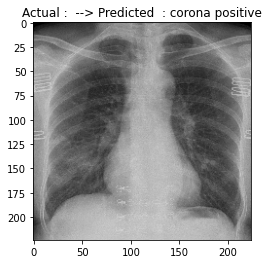

In [ ]:
pred = model_predict(img_covid, "")

## Conclusion

I have chosen a different dataset that one described in Task's description. The dataset I use is newer and has more images. I was surprised by the effectiveness of Transfer Learning. Right out of the box MobileNetV2 hits 70% accuracy on X ray images classification for Covid. With a bit of training it achieves over 93% accuracy. Transfer Learning saved enourmous amount of time, because I didn't have to make my own model, but just download an existing one. I also learnt how to manage larger amount of data (images) with Computer Vision problem. Because most of CNN are trained on ImageNet dataset (with over 13million images) it seems that these Networks can handle pretty big problems, I am keen of using transfer learning in the future.